# Wrapper Proto

In [1]:
import pandas as pd
import yfinance as yf

from mplchart.chart import Chart
from mplchart.primitives import Candlesticks, Volume
from mplchart.indicators import SMA, RSI, MACD

In [2]:
ticker = "AAPL"
prices = yf.Ticker(ticker).history(period="5y")
prices = prices.rename(columns=str.lower).rename_axis(index=str.lower)
prices

,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2019-09-16 00:00:00-04:00,52.671282,53.251870,52.630157,53.196228,84632400,0.0,0.0
2019-09-17 00:00:00-04:00,53.210747,53.418791,53.007539,53.389759,73274800,0.0,0.0
2019-09-18 00:00:00-04:00,53.476845,53.909868,53.084950,53.890514,101360000,0.0,0.0
2019-09-19 00:00:00-04:00,53.706659,54.130004,53.309925,53.452656,88242400,0.0,0.0
2019-09-20 00:00:00-04:00,53.554257,53.839710,52.608384,52.671280,221652400,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-09 00:00:00-04:00,220.820007,221.270004,216.710007,220.910004,67180000,0.0,0.0
2024-09-10 00:00:00-04:00,218.919998,221.479996,216.729996,220.110001,51591000,0.0,0.0
2024-09-11 00:00:00-04:00,221.460007,223.089996,217.889999,222.660004,44587100,0.0,0.0


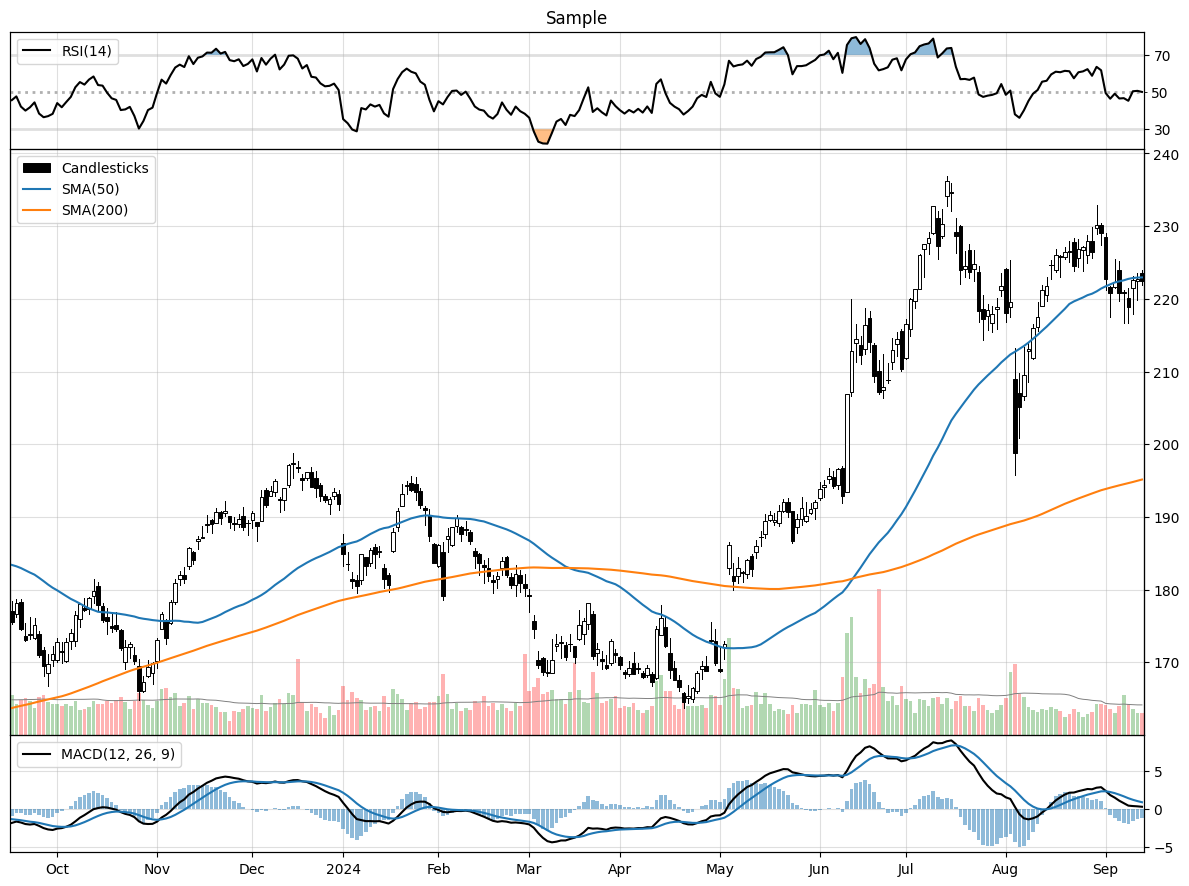

In [3]:
max_bars = 250
indicators = [Candlesticks(), Volume(), SMA(50), SMA(200), RSI(), MACD()]

chart = Chart(title="Sample", max_bars=max_bars)
chart.plot(prices, indicators)

In [ ]:
import warnings

from mplchart.model import Wrapper


SOLID_LINE = "solid"
HISTOGRAM = "bars"
DASHED_LINE = "dashed"
UPPER_LIMIT = "upper-limit"
LOWER_LIMIT = "lower-limit"


class WrapperProto(Wrapper):
    def __init__(self, indicator):
        self.indicator = indicator

    @property
    def same_scale(self):
        return getattr(self.indicator, "same_scale", False)

    def get_axes(self, chart):
        target = "samex" if self.same_scale else "below"
        return chart.get_axes(target)

    def get_series(self, data, name):
        if data.__class__.__name__ == "Series":
            series = data
        else:
            series = data[name]
        return series

    def series_data(self, data, name):
        series = self.get_series(data, name)
        return series.index.values, series.values

    def get_style(self, name=None, **kwds):
        style_map = getattr(self.indicator, "style_map", dict())

        for key, value in kwds.items():
            skey = name + ":" + key if name else key
            value = style_map.get(skey, value)

    def plot_line(self, series, ax, name=None, label=None):
        xv, yv = series.index.values, series.values
        kwds = self.get_style(name, linestyle=None, linewidth=None, color=None)
        ax.plot(xv, yv, label=label, **kwds)

    def plot_bars(self, series, ax, name=None, label=None):
        xv, yv = series.index.values, series.values
        kwds = self.get_style(name, alpha=0.5, width=0.8, color=None)
        ax.bar(xv, yv, label=label, **kwds)

    def plot_band(self, lower, upper, ax, name=None, label=None):
        xv, yv = lower.index.values, lower.values
        xv, zv = upper.index.values, upper.values
        kwds = self.get_style(name, alpha=0.2, color=None)
        ax.fill_between(xv, yv, zv, interpolate=True, label=label, **kwds)

    def plot_result(self, data, chart, ax=None):
        if ax is None:
            ax = self.get_axes(chart)

        upper_limit, lower_limit = None, None

        for name, flags in self.indicator.output_flags.items():
            label = repr(self) if name in ("real", "interer") else name
            for flag in flags:
                if flag == HISTOGRAM:
                    xv, yv = self.series_data(data, name)
                    ax.bar(xv, yv, alpha=0.5, width=0.8, label=label)
                    continue

                linestyle = None

                if flag == SOLID_LINE:
                    linestyle = "-"
                elif flag == DASHED_LINE:
                    linestyle = "--"
                elif flag == UPPER_LIMIT:
                    upper_limit = name
                    linestyle = "-."
                elif flag == LOWER_LIMIT:
                    lower_limit = name
                    linestyle = "-."
                else:
                    warnings.warn(f"Unknown flag {flag!r}")

                xv, yv = self.series_data(data, name)
                ax.plot(xv, yv, linestyle=linestyle, label=label)

        if upper_limit and lower_limit:
            xs, us = self.series_data(data, upper_limit)
            xs, ls = self.series_data(lower_limit)
            ax.fill_between(xs, ls, us, interpolate=True, alpha=0.2)